In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend
import sklearn
import scipy
from matplotlib import dates
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from scipy import stats
plt.style.use('Solarize_Light2')
%matplotlib inline

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w -a sushmit86@gmail.com

Author: sushmit86@gmail.com

Last updated: Fri Jan 08 2021

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 7.16.1

scipy     : 1.5.0
sklearn   : 0.23.1
mlxtend   : 0.18.0
numpy     : 1.18.5
seaborn   : 0.11.1
matplotlib: 3.2.2
pandas    : 1.0.5

Watermark: 2.1.0



In [3]:
df_data = pd.read_csv('screening_exercise_orders_v201810.csv')
df_data.head(n=1)

customer_id  gender                 date  value  predicted_gender
0         1000       0  2017-01-01 00:11:31  198.5                 1

In [4]:
df_data_to_work = df_data.copy()
df_data_to_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       13471 non-null  int64  
 1   gender            13471 non-null  int64  
 2   date              13471 non-null  object 
 3   value             13471 non-null  float64
 4   predicted_gender  13471 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 526.3+ KB


In [5]:
df_data_to_work['date'] = pd.to_datetime(df_data_to_work.date)
display(df_data_to_work.info())

grouped_customer_id = df_data_to_work.groupby('customer_id') 

assert grouped_customer_id.filter(lambda x: len(np.unique(x['gender'])) > 1).shape[0] == 0
assert grouped_customer_id.filter(lambda x: len(np.unique(x['predicted_gender'])) > 1).shape[0] == 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       13471 non-null  int64         
 1   gender            13471 non-null  int64         
 2   date              13471 non-null  datetime64[ns]
 3   value             13471 non-null  float64       
 4   predicted_gender  13471 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 526.3 KB


None

## A) Assemble a dataframe with one row per customer and the following columns:
- customer_id * gender * most_recent_order_date * order_count (number of orders placed by this customer)
- Sort the dataframe by customer_id ascending and display the first 10 rows.

In [6]:
df_data_to_work_agg = df_data_to_work.groupby(by = ['customer_id','gender']).agg(
    most_recent_order_date=pd.NamedAgg(column='date', aggfunc='max'),
    order_count=pd.NamedAgg(column='date', aggfunc='count')).reset_index()

df_data_to_work_agg.sort_values(by = ['customer_id'],inplace=True)
df_data_to_work_agg.head(n=10)

customer_id  gender most_recent_order_date  order_count
0         1000       0    2017-01-01 00:11:31            1
1         1001       0    2017-01-01 00:29:56            1
2         1002       1    2017-02-19 21:35:31            3
3         1003       1    2017-04-26 02:37:20            4
4         1004       0    2017-01-01 03:11:54            1
5         1005       1    2017-12-16 01:39:27            2
6         1006       1    2017-05-09 15:27:20            3
7         1007       0    2017-01-01 15:59:50            1
8         1008       0    2017-12-17 05:47:48            3
9         1009       1    2017-01-01 19:27:17            1

## B) Plot the count of orders per week for the store.


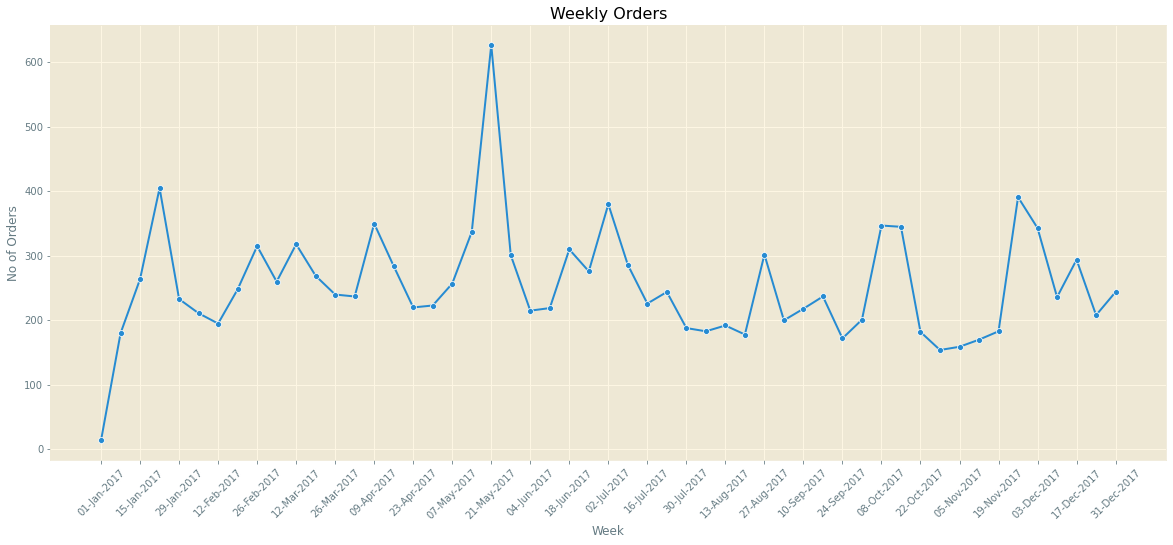

In [7]:
df_to_plot = df_data_to_work.set_index( ['date']).resample('W').agg({'customer_id':'size'}).reset_index()
fig,axs = plt.subplots(1,1, figsize = (20,8))
sns.lineplot(data= df_to_plot, x = 'date', y = 'customer_id',marker = 'o')
axs.set_title('Weekly Orders')
axs.set_xlabel('Week')
axs.set_xticklabels(df_to_plot.date.values[::2], rotation= 45)
axs.set(xticks=df_to_plot.date.values[::2])
axs.xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"))
axs.set_ylabel('No of Orders')
plt.show()

## B (Assumptions)
```Week over here refers from Monday to Sunday. For the solutions completeness I have included the the first data point i.e. 1-Jan-2017. However it only captures a day. If it were to me I would have excluded the point as it does not captures the whole week```

## C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? Justify your choice of method.

In [8]:
df_data_to_work_agg_value = df_data_to_work.groupby(by = ['customer_id','gender']).agg(
    total_value=pd.NamedAgg(column='value', aggfunc='sum')).reset_index()

df_data_to_work_agg_value.groupby(by = ['gender']).agg(
    mean_order_value=pd.NamedAgg(column='total_value', aggfunc='mean')).reset_index()

gender  mean_order_value
0       0        558.096789
1       1        534.139896

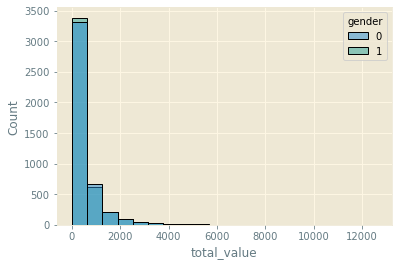

In [9]:
fig,axs = plt.subplots(1,1)
sns.histplot(df_data_to_work_agg_value,x="total_value", hue="gender",bins=20,ax=axs )
plt.show()

In [10]:
y0 = df_data_to_work_agg_value[df_data_to_work_agg_value.gender == 0].total_value.values
y1 = df_data_to_work_agg_value[df_data_to_work_agg_value.gender == 1].total_value.values
tStat, pValue = stats.ttest_ind(y0, y1) #run independent sample T-Test
print('P-Value:{0} T-Statistic:{1}'.format(pValue,tStat))

P-Value:0.1367325181357438 T-Statistic:1.4882053946708618


## Solution (C)
```Looking at the plot we can see that for the both the genders the total_value is skewed. Also there are outliers present in both the genders. To see if there is a significant difference between the means we can employ Independent Sample T-Test. The p-value for the test comes out to be 0.13. Hence at a 95% significance we can accept the null hypotheses i.e. the means for the gender 0 and gender 1 are equal```

## D) Generate a confusion matrix for the gender predictions of customers in this dataset. You should assume that there is only one gender prediction for each customer. What does the confusion matrix tell you about the quality of the predictions?

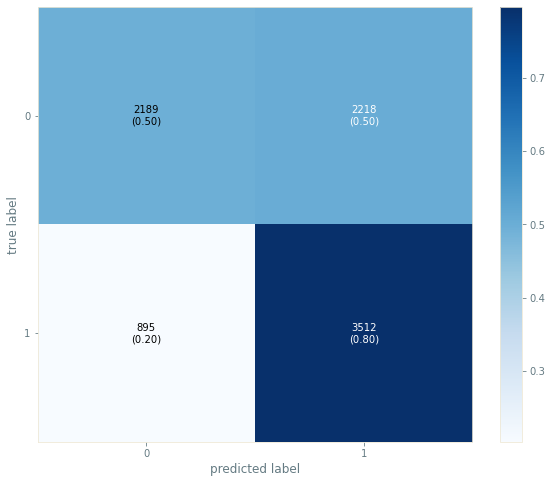

In [11]:
df_data_to_work_agg_predicted_gender = df_data_to_work.groupby(by = ['customer_id','gender']).agg(
    predicted_gender=pd.NamedAgg(column='predicted_gender', aggfunc='max')).reset_index()

y_true = df_data_to_work_agg_predicted_gender.gender
y_pred = df_data_to_work_agg_predicted_gender.predicted_gender

cm = confusion_matrix(y_true,y_pred)

fig,axs = plt.subplots(1,1, figsize = (10,8))
plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                               colorbar=True,axis = axs,figure = fig)
plt.show()

## Solution (D)
```Looking at the confusion matrix it seems the model does a good job of predicting gender 1 while does a poor job for prediction gender 0```

## E) Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph, and please be specific.

## Solution(E)
``` I have frequently used machine learning models for solving quite a few business problems. Working for Staples one of the major challenges for us has been to reduce customer churn. By leveraging classification predictive models and using customer attributes I have deployed a very successful churn model. Python has been the main tool I have used for developing this. Most of my data transformations are done using pandas. For EDA I extensively used matplotlib and seaborn. For the modeling piece, I leveraged sklearn api. ```